# MSCF 46982 Market Microstructure and Algorithmic Trading
# Fall 2025 Mini 2

Before you turn this assignment in, make sure everything runs as
expected. First, **restart the kernel**: by selecting
Kernel$\rightarrow$Restart Kernel from the menubar (or the `0,0`
keyboard shortcut) and then **run all cells** by selecting
Run$\rightarrow$Run All Cells from the menubar.

Make sure you replace all instances `YOUR CODE HERE` or "YOUR ANSWER
HERE" with your solution and remove the `notimplemented` exception.


As indicated in the syllabus, you are encouraged to discuss the
material presented in class but not of the specifics of assignments
(including this one).


---

In [1]:
import os
os.environ['PYKX_JUPYTERQ'] = 'true'
os.environ['PYKX_4_1_ENABLED'] = 'true'
import pykx as kx


<frozen importlib._bootstrap>:488: PyKXWarning: Unable to connect user QHOME to PyKX QHOME via symlinks.
To permanently disable attempts to create symlinks you can
	1. Set the environment variable "PYKX_IGNORE_QHOME" = True.
	2. Update the file ".pykx-config" using kx.util.add_to_config({'PYKX_IGNORE_QHOME': 'True'})
Error: [WinError 1314] A required privilege is not held by the client: 'C:\\Users\\jacob\\Desktop\\Fin Computing I\\Mkt Micro and Algo\\06. Advanced NYSE Daily TAQ Queries.ipynb' -> 'C:\\Users\\jacob\\Desktop\\Fin Computing I\\env\\Lib\\site-packages\\pykx\\lib\\4-1-libs\\06. Advanced NYSE Daily TAQ Queries.ipynb'



PyKX now running in 'jupyter_qfirst' mode. All cells by default will be run as q code. 
Include '%%py' at the beginning of each cell to run as python code. 


## Market Impact ##

Deciding when and how to trade large orders is fundamental to
designing algorithmic trading engines (algos).  VWAP and TWAP were
some of the first algos.  To design algos effectively, volume, spread
and volatility profiles (built in homework 3) are needed.

We now turn our attention to the cost that comes with every trading
decision - the market impact.

This assignment will walk you through querying and efficiently merging
a large trade and quote dataset, using the [Lee and Ready (1991)][LR]
algorithm to determine if the trades are buyer or seller initiated,
and finally using regression to compute ([Kyle's lambda 1985][KL]) as
a measure if each stock's liquidity. The final question asks you to
predict market impact using the Square Root Law.

The previous assignment focused on locally analyzing the raw trade and
quote data.  Now that our analysis is growing, this is not be
possible.  This assignment pushes much of the heavy lifting back to
the Kdb+ server and returns summarized data to your Jupyter Notebook
for further analysis.

[LR]: https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1540-6261.1991.tb02683.x
[KL]: https://www.rhsmith.umd.edu/files/Documents/Centers/CFP/research/kyle1985.pdf


We start by opening a connection to the NYSE Daily TAQ database. The
symbol saved in `h` is a Kdb+ file handle.  It will be used for all
database communication.

NOTE: The database is located on a CMU server - behind the firewall.
If you are doing this assignment from home, you will need to connect
to the CMU network using the [Cisco AnyConnect VPN][] software.

[Cisco AnyConnect VPN]:
https://www.cmu.edu/computing/services/endpoint/network-access/vpn/index.html
"Cisco AnyConnect VPN"


In [2]:
\c 5 100
/ windows and mac/linux use different environment variables
home:`HOME`USERPROFILE "w"=first string .z.o
upf:0N!` sv (hsym`$getenv home),`cmu_userpass.txt
h:`$":tcps://tpr-mscf-kx.tepper.cmu.edu:5000:",first read0 upf


### Part A (3 Points) ###

Complete the `tradequery` function so that it:

1. **Selects trade information for a list of stocks for a single day
   and the given time range and trade conditions.**

Given a start time, end time, list of symbol and string of desired
trade conditions, return a table with only the date,time,sym,price and
size columns from the `trade` table.


In [3]:
/ (s)tart (t)ime, (e)nd (t)ime, list of (s)ym, trade (c)ondition codes, (d)a(t)e
tradequery:{[st;et;s;c;dt]
    t:select date,time,sym,price,size from trade where date=dt, sym in s, time within (st;et), cond in c;
    t}

In [4]:
/ list of symbols in the dow jones industria average (djia)
syms:`MMM`AXP`AAPL`BA`CAT`CVX`CSCO`KO`DIS`DOW
syms,:`XOM`GS`HD`IBM`INTC`JNJ`JPM`MCD`MRK`MSFT
syms,:`NKE`PFE`PG`TRV`UTX`UNH`VZ`V`WMT`WBA

/ pass function to the database for execution
h (tradequery;09:30;09:35;syms;" ";2020.02.03)

date       time                 sym  price  size
------------------------------------------------
2020.02.03 0D09:30:00.104222076 AAPL 304.25 200 
2020.02.03 0D09:30:00.104222222 AAPL 304.25 300 
2020.02.03 0D09:30:00.115302599 AAPL 304.16 100 
2020.02.03 0D09:30:00.420630361 AAPL 304.18 120 
2020.02.03 0D09:30:00.425902385 AAPL 304.18 100 
..


Your results should match the following:
```
2020.02.03 0D09:30:00.104222076 AAPL 304.25 200 
2020.02.03 0D09:30:00.104222222 AAPL 304.25 300 
2020.02.03 0D09:30:00.115302599 AAPL 304.16 100 
2020.02.03 0D09:30:00.420630361 AAPL 304.18 120 
2020.02.03 0D09:30:00.425902385 AAPL 304.18 100 
..
```

In [5]:
rnd:{x*"j"$y%x}
assert:{if[not x~y;'"expecting '",(-3!x),"' but found '",(-3!y),"'"]}
/ confirm all columns are included
assert[`date`time`sym`price`size] cols h (tradequery;0D09:30;0D16:00;`BAC;"O";2020.02.03)
/ confirm schema is correct
assert["dnsfi"] first flip value meta h (tradequery;0D09:30;0D16:00;`BAC;"O";2020.02.01)
/ confirm query only selects specified dates
assert[1#2020.02.10]  exec distinct date from h (tradequery;0D09:30;0D16:00;`BAC;"O";2020.02.10)
/ confirm only requested sym has been returned
assert[`BAC`TSLA] exec distinct sym from h (tradequery;0D09:30;0D16:00;`BAC`TSLA;"O";2020.02.03)
/ confirm only data within the expected time range is returned
assert[1b] all within[;09:30 16:00]exec time from h (tradequery;0D09:30;0D16:00;`BAC;"O";2020.02.10)
assert[1b] all within[;09:30 12:00]exec time from h (tradequery;0D09:30;0D12:00;`BAC;"O";2020.02.10)
/ confirm only selected condition codes have been returned
assert[1] count h (tradequery;0D09:30;0D16:00;`BAC;"O";2020.02.10)
assert[5348] count h (tradequery;0D09:30;0D10:00;`BAC;" O";2020.02.10)

In [6]:
timeit:{[f;x]system "ts ", last[get f],"[",(1_-1_-3!x),"]"}
/ check that the function is implemented efficiently
assert[1b] 2383968>=0N!last h (timeit;tradequery;(0D09:30;0D10:00;`BAC;" O";2020.02.10))

### Part B (3 Points) ###

Without having actual order information, we will need to first
guesstimate if each trade is buyer or seller initiated using the Lee
and Ready algorithm:

- If trade is closer to bid, it is seller initiated
- Else if trade is closer to ask, it is buyer initiated
- Else:
  - If last tick was an uptick, it is buyer initiated
  - Else it was seller initiated

With the trade information in hand, we can determine if each trade is
an up-tick or down-tick.

Complete the `tickquery` function so that it
1. Selects trade information for a list of stocks for a single days
   for the given time range and trade conditions.
2. **Adds a new column `tick` that indicates if the trade was above or
   below the previous trade (deferring to the trades before it in the
   case of no change).**


In [7]:
/ (s)tart (t)ime, (e)nd (t)ime, list of (s)ym, trade (c)ondition codes, (d)a(t)e
tickquery:{[st;et;s;c;dt]
    t:select date,time,sym,price,size from trade where date=dt, sym in s, time within (st;et), cond in c;
    t:update tick:fills -1 0N 1@1+signum price-prev[first price;price] by sym from t;
    t}

In [8]:
/ pass function to the database for execution
h (tickquery;09:30;09:35;syms;" ";2020.02.03)

date       time                 sym  price  size tick
-----------------------------------------------------
2020.02.03 0D09:30:00.104222076 AAPL 304.25 200      
2020.02.03 0D09:30:00.104222222 AAPL 304.25 300      
2020.02.03 0D09:30:00.115302599 AAPL 304.16 100  -1  
2020.02.03 0D09:30:00.420630361 AAPL 304.18 120  1   
2020.02.03 0D09:30:00.425902385 AAPL 304.18 100  1   
..


Your results should match the following:
```
date       time                 sym  price  size tick
-----------------------------------------------------
2020.02.03 0D09:30:00.104222076 AAPL 304.25 200      
2020.02.03 0D09:30:00.104222222 AAPL 304.25 300      
2020.02.03 0D09:30:00.115302599 AAPL 304.16 100  -1  
2020.02.03 0D09:30:00.420630361 AAPL 304.18 120  1   
2020.02.03 0D09:30:00.425902385 AAPL 304.18 100  1   
..
```

In [9]:
/ confirm all columns are included
assert[`date`time`sym`price`size`tick] cols h (tickquery;0D09:30;0D16:00;syms;"O";2020.02.03)
/ confirm schema is correct
assert["dnsfij"] first flip value meta h (tickquery;0D09:30;0D09:32;syms;"O";2020.02.01)
/ confirm queried data is accurate
assert[32] count h (tickquery;0D09:30;0D09:32;syms;"O";2020.02.03)
assert[`AAPL`MSFT!-289 85] `AAPL`MSFT#exec sum tick by sym from h (tickquery;0D09:30;0D09:32;syms;" ";2020.02.03)

In [10]:
/ check that the function is implemented efficiently
assert[1b] 81160096>=0N!last h (timeit;tickquery;(0D09:30;0D09:32;syms;"O";2020.02.03))

### Part C (3 Points) ###

To continue with our attempt to determine if each trade is buyer or
seller initiated by using the Lee and Ready algorithm, we need to mark
if each trade was above or below the mid price. This problem requires
you to (efficiently) join the previously created `trade` query with
the `nbbo` table.

Complete the `taqquery` function so that it:

1. Selects trade information for a list of stocks for a single days
   for the given time range and trade conditions.
2. Adds a new column `tick` that indicates if the trade was above or
   below the previous trade (deferring to the trades before it in the
   case of no change).
3. **Queries the `time`, `sym`, `bsize`, `bid`, `ask`, and `asize`
   columns from the `nbbo` table for the specified date.**
4. **Uses the `aj` operator to join the results of this query to the
   results of the trade query - making sure that the first argument to
   the `aj` operator includes all the necessary columns (and in the
   correct order).**

NOTE: In order for this query to finish in a reasonable time, Kdb+
must be able to quickly find the right quote for each trade.  Make
sure your query of the nbbo table maintains a `` `p`` attribute on the
sym column, or apply a new one if it doesn't already have one.


In [11]:
/ (s)tart (t)ime, (e)nd (t)ime, list of (s)ym, trade (c)ondition codes, (d)a(t)e
taqquery:{[st;et;s;c;dt]
    t:select date,time,sym,price,size from trade where date=dt, sym in s, time within (st;et), cond in c;
    t:update tick:fills -1 0N 1@1+signum price-prev[first price;price] by sym from t;
    t:aj[`sym`time;t] select sym,time,bsize,bid,ask,asize from nbbo where date=dt;
    t}

In [12]:
/ pass function to the database for execution
h (taqquery;0D09:30;0D09:35;syms;" ";2020.02.03)

date       time                 sym  price  size tick bsize bid    ask    asize
-------------------------------------------------------------------------------
2020.02.03 0D09:30:00.104222076 AAPL 304.25 200       1     304.16 304.33 1    
2020.02.03 0D09:30:00.104222222 AAPL 304.25 300       1     304.16 304.33 1    
2020.02.03 0D09:30:00.115302599 AAPL 304.16 100  -1   1     304.16 304.33 1    
2020.02.03 0D09:30:00.420630361 AAPL 304.18 120  1    1     304.17 304.19 14   
2020.02.03 0D09:30:00.425902385 AAPL 304.18 100  1    1     304.17 304.19 14   
..


Your results should match the following:
```
date       time                 sym  price  size tick bsize bid    ask    asize
-------------------------------------------------------------------------------
2020.02.03 0D09:30:00.104222076 AAPL 304.25 200       1     304.16 304.33 1    
2020.02.03 0D09:30:00.104222222 AAPL 304.25 300       1     304.16 304.33 1    
2020.02.03 0D09:30:00.115302599 AAPL 304.16 100  -1   1     304.16 304.33 1    
2020.02.03 0D09:30:00.420630361 AAPL 304.18 120  1    1     304.17 304.19 14   
2020.02.03 0D09:30:00.425902385 AAPL 304.18 100  1    1     304.17 304.19 14   
..
```

In [13]:
/ confirm all columns are included
assert[`date`time`sym`price`size`tick`bsize`bid`ask`asize] cols h (taqquery;09:30;16:00;syms;"O";2020.02.03)
/ confirm schema is correct
assert["dnsfijiffi"] first flip value meta h (taqquery;0D09:30;0D09:32;syms;"O";2020.02.03)
/ confirm queried data is accurate
assert[32] count h (taqquery;0D09:30;0D09:32;syms;"O";2020.02.03)
assert[`sym`bid`ask!(`XOM;61.08;61.11)] `sym`bid`ask#last h (taqquery;0D09:30;0D09:32;syms;" ";2020.02.03)

In [14]:
/ check that the function is implemented efficiently
assert[1b] 81160800>=0N!last h (timeit;taqquery;(0D09:30;0D09:32;syms;" ";2020.02.03))

### Part D (3 Points) ###

With the trade and quote data now joined, it is possible to compute
the prevailing mid price at each trade and finally determine the
assumed `side` of each trade.  While we will never know the real
intention of each trade (because it will always include both a buyer
and sell, we can create a good estimate of the more aggressive side of
the trade buy using the Lee and Ready Algorithm.

Complete the `landrquery` function so that it:

1. Selects trade information for a list of stocks for a single days
   for the given time range and trade conditions.
2. Adds a new column `tick` that indicates if the trade was above or
   below the previous trade (deferring to the trades before it in the
   case of no change).
3. Queries the `time`, `sym`, `bsize`, `bid`, `ask`, and `asize`
   columns from the `nbbo` table for the specified date.
4. Uses the `aj` operator to join the results of this query to the
   results of the trade query - making sure that the first argument to
   the `aj` operator includes all the necessary columns (and in the
   correct order).
5. **Adds a `mid` price column to the table**
6. **Adds a `side` column that is calculated by using the Lee & Ready algorithm**

Again, the Lee and Ready algorithm is defined here.  Using the `tick`
column from step 2 and the mid price from step 5, you should be able
to use the vector conditional operator `?[;;]` (in fact, you will use
it two times) to determine the side of the trade.

- If trade is closer to bid, it is seller initiated
- Else if trade is closer to ask, it is buyer initiated
- Else:
  - If last tick was an uptick, it is buyer initiated
  - Else it was seller initiated


In [15]:
/ (s)tart (t)ime, (e)nd (t)ime, list of (s)ym, trade (c)ondition codes, (d)a(t)e
landrquery:{[st;et;s;c;dt]
    t:select date,time,sym,price,size from trade where date=dt, sym in s, time within (st;et), cond in c;
    t:update tick:fills -1 0N 1@1+signum price-prev[first price;price] by sym from t;
    t:aj[`sym`time;t] select sym,time,bsize,bid,ask,asize from nbbo where date=dt;
    t:update mid:.5*bid+ask from t;
    t:update side:?[price>mid;1;?[price<mid;-1;tick]] from t;
    t}

In [16]:
/ pass function to the database for execution
h (landrquery;0D09:30;0D09:35;syms;" ";2020.02.03)

date       time                 sym  price  size tick bsize bid    ask    asize mid     side
--------------------------------------------------------------------------------------------
2020.02.03 0D09:30:00.104222076 AAPL 304.25 200       1     304.16 304.33 1     304.245 1   
2020.02.03 0D09:30:00.104222222 AAPL 304.25 300       1     304.16 304.33 1     304.245 1   
2020.02.03 0D09:30:00.115302599 AAPL 304.16 100  -1   1     304.16 304.33 1     304.245 -1  
2020.02.03 0D09:30:00.420630361 AAPL 304.18 120  1    1     304.17 304.19 14    304.18  1   
2020.02.03 0D09:30:00.425902385 AAPL 304.18 100  1    1     304.17 304.19 14    304.18  1   
..


Your results should match the following:
```
date       time                 sym  price  size tick bsize bid    ask    asize mid     side
--------------------------------------------------------------------------------------------
2020.02.03 0D09:30:00.104222076 AAPL 304.25 200       1     304.16 304.33 1     304.245 1   
2020.02.03 0D09:30:00.104222222 AAPL 304.25 300       1     304.16 304.33 1     304.245 1   
2020.02.03 0D09:30:00.115302599 AAPL 304.16 100  -1   1     304.16 304.33 1     304.245 -1  
2020.02.03 0D09:30:00.420630361 AAPL 304.18 120  1    1     304.17 304.19 14    304.18  1   
2020.02.03 0D09:30:00.425902385 AAPL 304.18 100  1    1     304.17 304.19 14    304.18  1   
..
```

In [17]:
/ confirm all columns are included
assert[`date`time`sym`price`size`tick`bsize`bid`ask`asize`mid`side] cols h (landrquery;0D09:30;0D16:00;syms;"O";2020.02.03)
/ confirm schema is correct
assert["dnsfijiffifj"] first flip value meta h (landrquery;0D09:30;0D09:32;syms;"O";2020.02.01)
/ confirm queried data is accurate
assert[32] count h (landrquery;0D09:30;0D09:32;syms;"O";2020.02.03)
assert[([]sym:2#`XOM;side:1 -1)] `sym`side#-2#h (landrquery;0D09:30;0D09:32;syms;" ";2020.02.03)

In [18]:
/ check that the function is implemented efficiently
assert[1b] 81162048>=0N!last h (timeit;landrquery;(0D09:30;0D09:32;syms;" ";2020.02.03))

### Part E (3 Points) ###

We now have the assumed `side` of each trade and can begin computing
minute summaries 'flow' so the size of the data returned is not very
large.

Complete the `landrquerysumary` function so that it:

1. Selects trade information for a list of stocks for a single days
   for the given time range and trade conditions.
2. Adds a new column `tick` that indicates if the trade was above or
   below the previous trade (deferring to the trades before it in the
   case of no change).
3. Queries the `time`, `sym`, `bsize`, `bid`, `ask`, and `asize`
   columns from the `nbbo` table for the specified date.
4. Uses the `aj` operator to join the results of this query to the
   results of the trade query - making sure that the first argument to
   the `aj` operator includes all the necessary columns (and in the
   correct order).
5. Adds a `mid` price column to the table
6. Adds a `side` column that is calculated by using the Lee & Ready
   algorithm
7. **Computes the net quantity traded (buy size - sell size), open and
   closing mid prices for each sym of each window (in minutes).
8. **Computes the change in closing mid price between windows (using
   the opening price for the first window). The returned table should
   have five columns: `` `date`minute`sym`size`dprice``**


In [19]:
/ (s)tart (t)ime, (e)nd (t)ime, list of (s)ym, trade (c)ondition codes, (w)indow size in minutes, (d)a(t)e
landrquerysummary:{[st;et;s;c;w;dt]
    t:select date,time,sym,price,size from trade where date=dt, sym in s, time within (st;et), cond in c;
    t:update tick:fills -1 0N 1@1+signum price-prev[first price;price] by sym from t;
    t:aj[`sym`time;t] select sym,time,bsize,bid,ask,asize from nbbo where date=dt;
    t:update mid:.5*bid+ask from t;
    t:update side:?[price>mid;1;?[price<mid;-1;tick]] from t;
    t:select size:sum size*side,open:first mid,close:last mid by date,time:w xbar time,sym from t;
    t:update dprice:deltas[first open;close] by sym from t;
    t:delete open,close from t;
    t}

In [20]:
w:0D00:05 / define window size
/ pass function to the database for execution
h (landrquerysummary;09:30;09:35;syms;" ";w;2020.02.03)

date       time                 sym | size   dprice
------------------------------------| -------------
2020.02.03 0D09:30:00.000000000 AAPL| -82924 2.245 
2020.02.03 0D09:30:00.000000000 AXP | -2456  0.365 
2020.02.03 0D09:30:00.000000000 BA  | 571    0.115 
2020.02.03 0D09:30:00.000000000 CAT | 6434   0.01  
2020.02.03 0D09:30:00.000000000 CSCO| -9083  -0.035
..


Your results should match the following:
```
date       time                 sym | size   dprice
------------------------------------| -------------
2020.02.03 0D09:30:00.000000000 AAPL| -82924 2.245 
2020.02.03 0D09:30:00.000000000 AXP | -2456  0.365 
2020.02.03 0D09:30:00.000000000 BA  | 571    0.115 
2020.02.03 0D09:30:00.000000000 CAT | 6434   0.01  
2020.02.03 0D09:30:00.000000000 CSCO| -9083  -0.035
..
```

In [21]:
/ confirm all columns are included
assert[`date`time`sym`size`dprice] cols h (landrquerysummary;09:30;16:00;syms;"O";w;2020.02.03)
/ confirm schema is correct
assert["dnsjf"] first flip value meta h (landrquerysummary;09:30;09:32;syms;"O";w;2020.02.01)
/ confirm queried data is accurate
assert[180] count h (landrquerysummary;09:30;10:00;syms;" ";w;2020.02.03)
/ confirm deltas don't cross sym boundaries
assert[-2456 0.36] rnd[.01] value h[(landrquerysummary;09:30;10:00;syms;" ";w;2020.02.03)](2020.02.03;0D09:30;`AXP)
/ confirm deltas are across (not within) windows
assert[-3664 0.025] rnd[.001] value h[(landrquerysummary;09:30;10:00;syms;" ";w;2020.02.03)](2020.02.03;0D09:35;`AXP)


In [22]:
/ check that the function is implemented efficiently
assert[1b] 81164656>=0N!last h (timeit;landrquerysummary;(09:30;10:00;syms;" ";w;2020.02.03))

NYSE Daily TAQ Kdb+ tables are designed to perform well on daily
queries. Our `landrquerysumary` function produces Lee and Ready
summary statistics for a list of symbols with minutely buckets `w` on
a single date. We can run the query over multiple dates and combine
the results locally.  We don't want to run a very long function on the
server, (it is not fair for everyone else and there is a per-client
timeout) so we should loop over each date locally.


In [23]:
/ here comes the heavy lifting, we now query a full day's worth of data
/ and loop over 4 days.  Written efficiently, your query should only take a few seconds
show t:raze {[dt]h (landrquerysummary;0D09:30;0D16:00;syms;" ";w;dt)} each 2020.02.03+til 4

The results should match the following:
```
date       time                 sym | size   dprice
------------------------------------| -------------
2020.02.03 0D09:30:00.000000000 AAPL| -82924 2.245 
2020.02.03 0D09:30:00.000000000 AXP | -2456  0.365 
2020.02.03 0D09:30:00.000000000 BA  | 571    0.115 
2020.02.03 0D09:30:00.000000000 CAT | 6434   0.01  
2020.02.03 0D09:30:00.000000000 CSCO| -9083  -0.035
..
```

### Part F (2 Points) ###

With the traded volumes and resulting market moves, we can now regress
Kyle's lambda from the formula:

$$\Delta m_t = \mu + \lambda q_t + \epsilon_t$$

where: 
- $\Delta m_t$ is the change in mid price over time $t$
- $\mu$ is the stock trend/drift
- $q_t$ is the order imbalance (total buy - sell orders)

This problem asks you to write a function that will regress two
vectors `x` and `y` with the option of also fitting the y intercept.

The Kdb+ `lsq` operator is written to perform least squares regression
over multiple dimensions.  we will only be using it on a single
dimension `x` vs `y`.  Our `regress` function will accept vectors,
convert them to matrices before finally return the result as a vector
as well.

Complete the `regress` function so that it: 

1. Checks the `int` parameter and either converts `y` into a
   one-column matrix or a two-column matrix with the first column
   being a list of ones (if `int` is true)
2. Converts vector `x` into a one-column matrix.
3. Uses the `lsq` operator to perform least squares regression on the
   two matrices
4. Returns the first dimension of the resulting one-column matrix.



In [24]:
/ perform ordinary least squares regression on `x` and `y` optionally fitting the `y` (int)ercept
regress:{[int;x;y]
 X:$[int;(count[x]#1f;x);enlist x];
 r:first enlist[y] lsq X;
 r}

In [25]:
regress[1b;1 2 3f;1 2 3f]

2.56395e-16 1


Your results should match the following:
```
2.56395e-16 1
```

In [26]:
/ confirm regression returns the correct results
assert[9h] type regress[0b;1 2 3f;1 2 3f]
assert[1] count regress[0b;1 2 3f;1 2 3f]
assert[9h] type regress[1b;1 2 3f;1 2 3f]
assert[2] count regress[1b;1 2 3f;1 2 3f]
assert[enlist 1f] rnd[.01] regress[0b;1 2 3f;1 2 3f]
assert[0 1f] rnd[.01] regress[1b;1 2 3f;1 2 3f]
assert[4 -1f] rnd[.01] regress[1b;1 2 3f;3 2 1f]

### Part G (2 Points) ###

Let's return to the task of computing Kyle's lambda for each of the
stocks in the DJIA for the few days of data stored in `t`.

Complete the `kyle` function so that it:

1. Regresses the price change column `dprice` against the net quantity
   traded column `size` for each `sym` in the table and stores the
   results in a `results` column. The values in the `results` column
   will be lists which we will need to 'pick apart'.
2. If `int` is true, adds a `mu` column that has the first value of
   **each** of the `results` rows.
3. Adds a `lambda` column that has the last value of **each** of the
   `results` rows.
4. Uses the `delete` operator to remove the `results` column.
5. Sort the table so the stock with the highest lambda is first and
   the smallest lambda is last.

The function will accept two parameters, `int` which specifies whether
we want to fit the stock drift and `t` which will be a table with the
`sym`, `size` and `dprice` columns.

The resulting table should have two (or three) columns. If `int` is
true, the table will have sym, mu and lambda columns, otherwise it
will only have sym and lambda.

NOTE: because Kdb+ overloads operators based on their type, it is
important that the values in the matrices passed to the `lsq` operator
are all "f"loats.  You will get a type error if this is not the case.


In [27]:
/ perform ordinary least squares regression on `x` and `y` optionally fitting the `y` (int)ercept
kyle:{[int;t]
 t:select results:regress[int;"f"$size;"f"$dprice] by sym from t;
 t:$[int;update mu:first each results from t;t];
 t:update lambda:last each results from t;
 t:delete results from t;
 `lambda xdesc t}

In [28]:
kyle[1b;update "f"$dprice,"f"$size from t] / make sure to pass "f"loat values

sym| mu           lambda      
---| -------------------------
BA | -0.02604877  4.234743e-05
UNH| -0.01321659  3.028998e-05
MMM| -0.007804546 1.197718e-05
MCD| -0.005012212 1.083753e-05
TRV| 0.009904599  8.196648e-06
..


Your results should match the following:
```
sym| mu           lambda      
---| -------------------------
BA | -0.02604877  4.234743e-05
UNH| -0.01321659  3.028998e-05
MMM| -0.007804546 1.197718e-05
MCD| -0.005012212 1.083753e-05
TRV| 0.009904599  8.196648e-06
..
```

In [29]:
/  confirm table is correctly sorted by lambda
assert[`BA`HD] (first;last)@\:key[kyle[0b;update "f"$dprice,"f"$size from t]]`sym
/ confirm kyle returns the correct results
assert[(30;`sym`lambda)] (count;cols)@\: kyle[0b;update "f"$dprice,"f"$size from t]
assert[(30;`sym`mu`lambda)] (count;cols)@\:kyle[1b;update "f"$dprice,"f"$size from t]
assert[(1#`lambda)!enlist 0.418 0.3] flip rnd[.001] 1e4*2#value kyle[0b;update "f"$dprice,"f"$size from t]
assert[`mu`lambda!(-260.49 -132.17;0.42 0.3)] flip rnd[.01] 1e4*2#value kyle[1b;update "f"$dprice,"f"$size from t]

### Part H (2 Points) ###

With the regression coefficients calculated, we can now compute the
expected price movement (impact) for each size in the multi-day Lee
and Ready summary table `t`.

For this problem you should:

1. Join the results of the `kyle` query (stored in the `k` variable)
   with the Lee and Ready summary table `t`
2. Add a new `impact` column which uses the net traded `size` in the
   time bucket with the computed `lambda` for that stock to 'predict'
   the price move

NOTE: This 'prediction' is completely *in sample* and should not be
taken literally.


In [30]:
k:kyle[0b;select sym,size:"f"$size,dprice:"f"$dprice from t]
t:update lambda,impact:size*lambda from t lj k

In [31]:
t

date       time                 sym | size   dprice lambda       impact      
------------------------------------| ---------------------------------------
2020.02.03 0D09:30:00.000000000 AAPL| -82924 2.245  1.566255e-06 -0.1298802  
2020.02.03 0D09:30:00.000000000 AXP | -2456  0.365  2.344531e-06 -0.005758169
2020.02.03 0D09:30:00.000000000 BA  | 571    0.115  4.184924e-05 0.02389592  
2020.02.03 0D09:30:00.000000000 CAT | 6434   0.01   4.463729e-06 0.02871964  
2020.02.03 0D09:30:00.000000000 CSCO| -9083  -0.035 5.468009e-07 -0.004966593
..


Your results should match the following:
```
date       time                 sym | size   dprice lambda       impact      
------------------------------------| ---------------------------------------
2020.02.03 0D09:30:00.000000000 AAPL| -82924 2.245  1.566255e-06 -0.1298802  
2020.02.03 0D09:30:00.000000000 AXP | -2456  0.365  2.344531e-06 -0.005758169
2020.02.03 0D09:30:00.000000000 BA  | 571    0.115  4.184924e-05 0.02389592  
2020.02.03 0D09:30:00.000000000 CAT | 6434   0.01   4.463729e-06 0.02871964  
2020.02.03 0D09:30:00.000000000 CSCO| -9083  -0.035 5.468009e-07 -0.004966593
..
```

In [32]:
/ confirm impact 'prediction' was performed correctly
assert[`date`time`sym`size`dprice`lambda`impact] cols t
assert[9360] count t
assert[-82924 2.25 0 -0.13] rnd[.01] value t[(2020.02.03;0D09:30;`AAPL)]
assert[-2254 -0.22 0 -0.004] rnd[.001] value t[(2020.02.03;0D09:40;`WMT)]

### Part I (2 Points) ###

Market impact is not - in fact - linear with the quantity traded.  The
Square Root 'Law' has been shown to be a good estimate of the market
impact, given a stock's average daily volume and volatility.

$$
I(Q)\sim\sigma\left(\frac{\mid Q\mid}{V}\right)^\frac{1}{2}
$$


This question requests that you determine the impact expected for
trading USD \$1M of each of the DJIA stocks.

Complete the `impact` function so that it:

1. Selects the sym,size and close data from the `daily` table for the
   given time window and symbols
2. Computes the average daily volume `adv`, daily volatility `vol` and
   last price `close` for each symbol
3. Adds a `qty` column which is derived from the provided `n`otional
   and last `close` price
4. Adds a column with the impact as a percent `impactpct` using the
   square root law (assuming proportionality 1)
5. Adds a column with the impact as a price `impactpx`

The resulting table should have the following columns: `sym`, `adv`,
`vol`, `close`, `qty`, `impactpct`, `impactpx`.

NOTE: make sure to use the `sdev` function on daily **log** returns
when computing volatility.


In [33]:
/ computes the expected impact (in dollars) for each (s)ym when trading (n)otional
/ average daily volume and standard deviation of each (s)ym are computed between (s)tart (d)ate and (e)nd (d)ate
impact:{[n;sd;ed;s]
    t:select from daily where date within (sd;ed), sym in s;
    t:select
      adv:avg size
      ,vol:sdev 1_deltas log close
      ,close:last close
    by sym from t;
    t:update qty:n%close from t;
    t:update impactpct:vol*sqrt qty%adv from t;
    t:update impactpx:impactpct*close from t;
    t}

In [34]:
show `impactpx xasc i:h (impact;1e6;2020.02.03;2020.02.28;syms)

Your results should match the following:
```
sym | adv          vol        close qty      impactpct    impactpx  
----| --------------------------------------------------------------
PFE | 3.902827e+07 0.0125824  33.65 29717.68 0.0003472014 0.01168333
KO  | 1.906932e+07 0.01333435 53.93 18542.56 0.0004158044 0.02242433
VZ  | 2.327759e+07 0.01690043 54.44 18368.85 0.0004747551 0.02584567
CSCO| 3.309875e+07 0.02425605 40.33 24795.44 0.0006638962 0.02677493
MRK | 1.899022e+07 0.01377078 77.75 12861.74 0.0003583798 0.02786403
..
```

In [35]:
/ confirm the table columns are correct
assert[`sym`adv`vol`close`qty`impactpct`impactpx] cols i
/ confirm the number of rows is correct
assert[30] count i
/ confirm adv is computed properly
assert[8318530 11580204] rnd[1] i[([]sym:`IBM`JNJ);`adv]
/ confirm volatility is computed properly
assert[0.0227 0.0109] rnd[1e-4] i[([]sym:`IBM`JNJ);`vol]
/ confirm qty is computed properly
assert[7634 7313] rnd[1] i[([]sym:`IBM`JNJ);`qty]
/ confirm impactpct is computed properly
assert[0.000689 0.000274] rnd[1e-6] i[([]sym:`IBM`JNJ);`impactpct]
/ confirm impactpx is computed properly
assert[0.0902 0.0375] rnd[1e-4] i[([]sym:`IBM`JNJ);`impactpx]


### Part J (2 Points) ###

When we begin buying (selling) a stock, it is likely this act begins
to push the price up (down).  This may not happen for a single order
(due to other market participants who may have more information than
us), but we should expect to see a pattern if we average over many
different orders.

It is common to chart the price movement of an order from the arrival
time to the end of all executions to see the price impact our order
imparted - and then past this time to see any reversion.

This graph is referred to as a 'markout'.  It may refer to price moves
for a single order with multiple child orders, or the average of
multiple orders to demonstrate the average impact or toxicity of an
order.

This question request that you generate a markout for all the orders
that result from trading an equal number of shares of each of the DJIA
stocks using a TWAP strategy.  Beginning at 9:30 and ending at 16:00
we will generate orders that trade an equal fraction of the shares
every 15 minutes.  We will unrealistically assume the price of each of
these orders gets executed in-full at the mid price exactly at the
time the order is placed.

In contrast to the examples introduced in class, this problem computes
all markouts in a single shot by using a 'long-and-skinny' table with
multiple lags.

Complete the `markout` function so that it:

1. Joins the provided table of orders with the nbbo table to find the
   mid price asof the order times
2. Uses the `cross` operator to duplicate the table for each of the n
   **seconds** before, the time itself, and n **seconds** after the
   order and adds the new `lag` column which is of type timespan ("n")
3. Uses the time and lag columns to create a new time column
   representing the markout time and joins the table with the nbbo
   table once again (this time using the new time column) to find the
   mid price of each sym for each of the lags
4. Computes the profit (taking the `qty` traded into account) from the
   execution time to each of the 2n+1 lags per sym
5. Sums the profits across syms for each `time` and `lag` - resulting
   in a table with three columns: `time`, `lag`, `pnl`
6. Averages each the profits and computes the error of profits across
   `time` for each `lag` - resulting in a table with three columns:
   `lag`, `pnl`, `err`

The function will accept three parameters, `n` which specifies the
number of lags before and after each order, `dt` which will be the
date these orders occurred on and a table of orders `t` which will
include three columns: `sym`, `qty` and `time`.

The resulting table should have the following columns: `lag`, `pnl`,
`err`.

NOTE: make sure to use the `sdev` function on profits to compute the
err

NOTE: make sure you don't compute the mid price for **every** row of
the `nbbo` table - that will be extremely slow.  compute the mid
**after** joining the bid and ask prices to your tables.


In [36]:
/ generates a markout table for (n) seconds before and (n) seconds after
/ on (d)a(t)e for the orders provided in (t)able
markout:{[n;dt;t]
    t:aj[`sym`time;t] select `p#sym,time,bid,ask from nbbo where date=dt;
    t:update mid0:.5*bid+ask from t;
    t:delete bid,ask from t;
    
    t:t cross ([]lag:0D00:00:01*neg[n]+til 1+2*n);
    
    t:update marktime:time+lag from t;
    t:aj[`sym`marktime;t] select `p#sym,marktime:time,bid,ask from nbbo where date=dt;
    t:update mid:.5*bid+ask from t;
    t:delete bid,ask,marktime from t;
    
    t:update pnl:qty*mid-mid0 from t;
    
    t:select pnl:sum pnl by time,lag from t;
    
    t:select pnl:avg pnl,err:sdev pnl by lag from t;
    t}

In [37]:
st:0D09:30
et:0D16:00
w:0D00:15
show m:h (markout;5;2020.02.03;([]sym:syms;qty:-1) cross ([]time:st+w*til 1+"j"$(et-st) div w))

Your results should match the following:
```
lag                  | pnl        err       
---------------------| ---------------------
-0D00:00:05.000000000| 0.02166667 0.3516117 
-0D00:00:04.000000000| 0.01351852 0.3170805 
-0D00:00:03.000000000| 0.03296296 0.2645615 
-0D00:00:02.000000000| 0.09851852 0.2041625 
-0D00:00:01.000000000| 0.05574074 0.09524971
..
```

In [38]:
/ confirm the table columns are correct
assert[`lag`pnl`err] cols m
/ confirm the number of rows is correct
assert[11] count m
/ confirm lag values are correct
assert[-0D00:00:05.000000000 0D00:00:05.000000000] (first;last)@\:key[m]`lag
/ confirm ret is computed properly
assert[-0.7541] rnd[.0001]sum value[m]`pnl
/ confirm err is computed properly
assert[7.5464] rnd[.0001]sum value[m]`err

In [39]:
.pykx.set[`m] .pykx.topd m

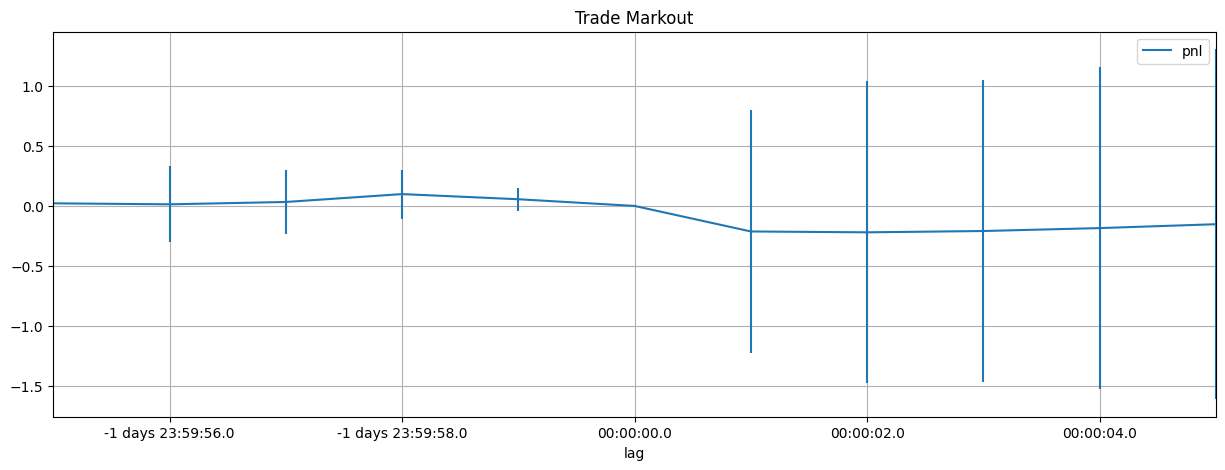

In [40]:
%%py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('default')
mpl.rcParams["figure.figsize"] = [15,5]
m.plot(title='Trade Markout',yerr='err')
plt.grid()